In [ ]:
!nvidia-smi

Wed May 25 02:21:59 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Install modules

In [ ]:
pip install datasets

     |████████████████████████████████| 342 kB 5.4 MB/s 
     |████████████████████████████████| 140 kB 51.0 MB/s 
     |████████████████████████████████| 1.1 MB 50.5 MB/s 
     |████████████████████████████████| 212 kB 55.8 MB/s 
     |████████████████████████████████| 127 kB 56.7 MB/s 
     |████████████████████████████████| 271 kB 55.3 MB/s 
     |████████████████████████████████| 144 kB 58.7 MB/s 
     |████████████████████████████████| 94 kB 4.2 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.2 MB 31.6 MB/s 
     |████████████████████████████████| 86 kB 6.1 MB/s 
     |████████████████████████████████| 596 kB 43.4 MB/s 
     |████████████████████████████████| 6.6 MB 61.7 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
from datasets import load_dataset

dataset = load_dataset("xnli",language='vi')

Using custom data configuration default-language=vi
Reusing dataset xnli (/root/.cache/huggingface/datasets/xnli/default-language=vi/1.1.0/818164464f9c9fd15776ca8a00423b074344c3e929d00a2c1a84aa5a50c928bd)


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['premise', 'hypothesis', 'label'],
        num_rows: 392702
    })
    test: Dataset({
        features: ['premise', 'hypothesis', 'label'],
        num_rows: 5010
    })
    validation: Dataset({
        features: ['premise', 'hypothesis', 'label'],
        num_rows: 2490
    })
})

In [ ]:
import pandas as pd

In [ ]:
train=pd.DataFrame(dataset['train'])

In [ ]:
train=train.sample(frac=1)

In [ ]:
valid=pd.DataFrame(dataset['validation'])

In [ ]:
test=pd.DataFrame(dataset['test'])

In [ ]:
valid.to_csv("/content/drive/MyDrive/vi-nli/raw_dataset/valid.csv",index=False)

In [ ]:
test.to_csv("/content/drive/MyDrive/vi-nli/raw_dataset/test.csv",index=False)

#Import modules

In [1]:
import pandas as pd
import re
import string
from transformers import AutoTokenizer,AutoConfig,AutoModelForSequenceClassification,get_linear_schedule_with_warmup
import matplotlib.pyplot as plt
from os.path import join
import os
from torch.utils.data import DataLoader, Dataset
import torch
from tqdm.auto import tqdm
import numpy as np
from sklearn.metrics import *

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
name='xlm-roberta-base'
max_length=128

root='/content/drive/MyDrive/vi-nli'
preprocessed_data=join(root,"preprocessed_data")
models=join(root,'models')
model_name=join(models,f'{name}-{max_length}')

In [4]:
os.makedirs(preprocessed_data, exist_ok=True)

In [5]:
tokenizer = AutoTokenizer.from_pretrained(name)

#Load dataset

In [ ]:
train=pd.read_csv(f'/content/drive/MyDrive/vi-nli/raw_dataset/train.csv')

In [ ]:
train

,premise,hypothesis,label
0,Hãy lấy ý tưởng rằng đàn ông trở nên ít cạnh t...,Một vợ chồng giảm testosterone trong đàn ông b...,1
1,Đúng nó muốn chạy ra và lấy đồ xong rồi nên um...,Anh ta là kẻ xấu xa nhất mà tôi biết ; anh ta ...,2
2,"Ngoài ra , kiểm soát hoạt động giúp đỡ để đảm ...",Các hoạt động kiểm soát không giúp được gì với...,2
3,Các ưu đãi thuế lớn thứ hai nhắm vào việc khuy...,Các ưu đãi thuế lớn thứ hai nhắm vào việc khuy...,2
4,Một kỵ sĩ khác đang chán anh ta với một con la...,Những kỵ sĩ khác đã đi xa anh ta .,2
...,...,...,...
392697,Cả dân số và nền kinh tế bắt đầu phát triển .,Nền kinh tế bắt đầu giảm nhanh khi dân số tăng...,2
392698,Tháng trước của tôi đã lấy một tôi đã tài trợ ...,Có một nhóm lớn trong chúng ta đã đi đến pizza...,0
392699,"Ngày nay , mọi người có vẻ thích điều đó .",Có những bằng chứng mà tất cả mọi người đều th...,0
392700,Chúng ta có thể có một cái bàn không ?,Chúng tôi không muốn có một cái bàn .,2


In [ ]:
valid=pd.read_csv("/content/drive/MyDrive/vi-nli/raw_dataset/valid.csv")

##Preprocessing

In [ ]:
punctuations=list(string.punctuation)

In [ ]:
def normalizer(text):

  def remove_meaningless_token(s):
    return re.sub(r'\b(jeez|yeah|uhhuh|uh|oh|huh|ừ|à)\b',' ',s)
  def uncased(s):
    return s.lower()

  def fix_whitespaces(s):
    return re.sub(r'\s+',' ',s)

  def remove_punctuations(s):
    chs=[]
    for ch in s:
      if ch not in punctuations:
        chs.append(ch)
      else:
        chs.append(" ")
    return "".join(chs)

  return fix_whitespaces(remove_meaningless_token(uncased(remove_punctuations(text)))).strip()

In [ ]:
train['clean_premise']=train['premise'].map(normalizer)

In [ ]:
valid['clean_premise']=valid['premise'].map(normalizer)

In [ ]:
test['clean_premise']=test['premise'].map(normalizer)
test['clean_hypothesis']=test['hypothesis'].map(normalizer)

In [ ]:
train['clean_hypothesis']=train['hypothesis'].map(normalizer)

In [ ]:
valid['clean_hypothesis']=valid['hypothesis'].map(normalizer)

In [ ]:
def seperate_sentence(s):
  return tokenizer.tokenize(s)

In [ ]:
def get_seq_len(s):
  tokens=seperate_sentence(s)
  return len(tokens)

In [ ]:
train['premise_seq_len']=train['clean_premise'].map(get_seq_len)
train['hypothesis_seq_len']=train['clean_hypothesis'].map(get_seq_len)

In [ ]:
valid['premise_seq_len']=valid['clean_premise'].map(get_seq_len)
valid['hypothesis_seq_len']=valid['clean_hypothesis'].map(get_seq_len)

In [ ]:
def seq_len_visualizer(x,y):
  fig, ax = plt.subplots(1, 1, sharex=True, sharey=True,figsize=(20,20))
  ax.bar(x,y)
  fig.show()

In [ ]:
max(train['premise_seq_len'].unique()),max(train['hypothesis_seq_len'].unique())

(441, 101)

In [ ]:
max(valid['premise_seq_len'].unique()),max(valid['hypothesis_seq_len'].unique())

(77, 37)

In [ ]:
min(train['premise_seq_len'].unique()),min(train['hypothesis_seq_len'].unique())

(0, 0)

In [ ]:
min(valid['premise_seq_len'].unique()),min(valid['hypothesis_seq_len'].unique())

(4, 2)

In [ ]:
train=train[~(train['premise_seq_len']==0)]

In [ ]:
train=train[~(train['hypothesis_seq_len']==0)]

In [ ]:
valid[(valid['premise_seq_len']==0)]

,premise,hypothesis,label,clean_premise,clean_hypothesis,premise_seq_len,hypothesis_seq_len


In [ ]:
valid[(valid['hypothesis_seq_len']==0)]

,premise,hypothesis,label,clean_premise,clean_hypothesis,premise_seq_len,hypothesis_seq_len


In [ ]:
samples1=train['clean_premise'].tolist()[:100]
samples2=train['clean_hypothesis'].tolist()[:100]
for i in range(100):
  print(samples1[i])
  print(samples2[i])
  print('\n')
  

hãy lấy ý tưởng rằng đàn ông trở nên ít cạnh tranh bởi vì phụ nữ khăng khăng với một vợ chồng điều đó làm giảm testosterone
một vợ chồng giảm testosterone trong đàn ông bằng cách khoảng 20


đúng nó muốn chạy ra và lấy đồ xong rồi nên um mình cố gắng nói rõ sao bạn không đi bay kites hay sao mà bạn không làm gì và
anh ta là kẻ xấu xa nhất mà tôi biết anh ta không bao giờ ra khỏi nhà


ngoài ra kiểm soát hoạt động giúp đỡ để đảm bảo rằng tất cả các giao dịch đều hoàn toàn và chính xác được ghi lại
các hoạt động kiểm soát không giúp được gì với bản ghi âm hoàn toàn của các giao dịch


các ưu đãi thuế lớn thứ hai nhắm vào việc khuyến khích lưu trữ quảng cáo quyền sở hữu nhà
các ưu đãi thuế lớn thứ hai nhắm vào việc khuyến khích chi tiêu quảng bá quyền sở hữu nhà


một kỵ sĩ khác đang chán anh ta với một con lance gai
những kỵ sĩ khác đã đi xa anh ta


những chuyện đó xảy ra mặc dù
nhưng tuy nhiên những thứ như vậy xảy ra


đưa những chiến binh của anh trở lại fena dim
các chiến binh đã đư

There are some meaningless tokens such as à, ừ, ... -> need to remove them

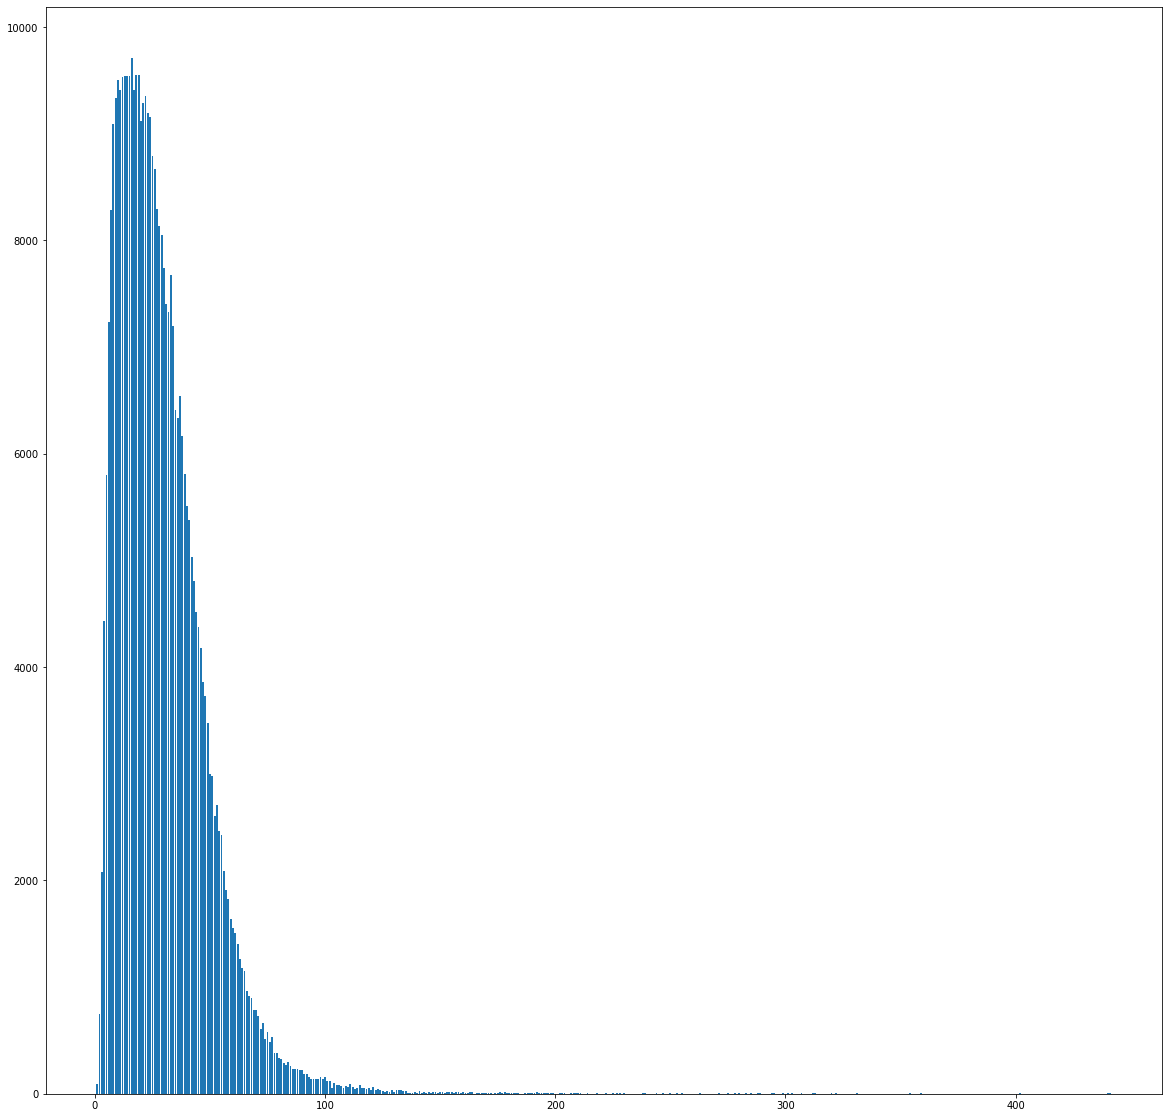

In [ ]:
dict_occurs=train['premise_seq_len'].value_counts().to_dict()
x,y=list(dict_occurs.keys()),list(dict_occurs.values())
seq_len_visualizer(x,y)

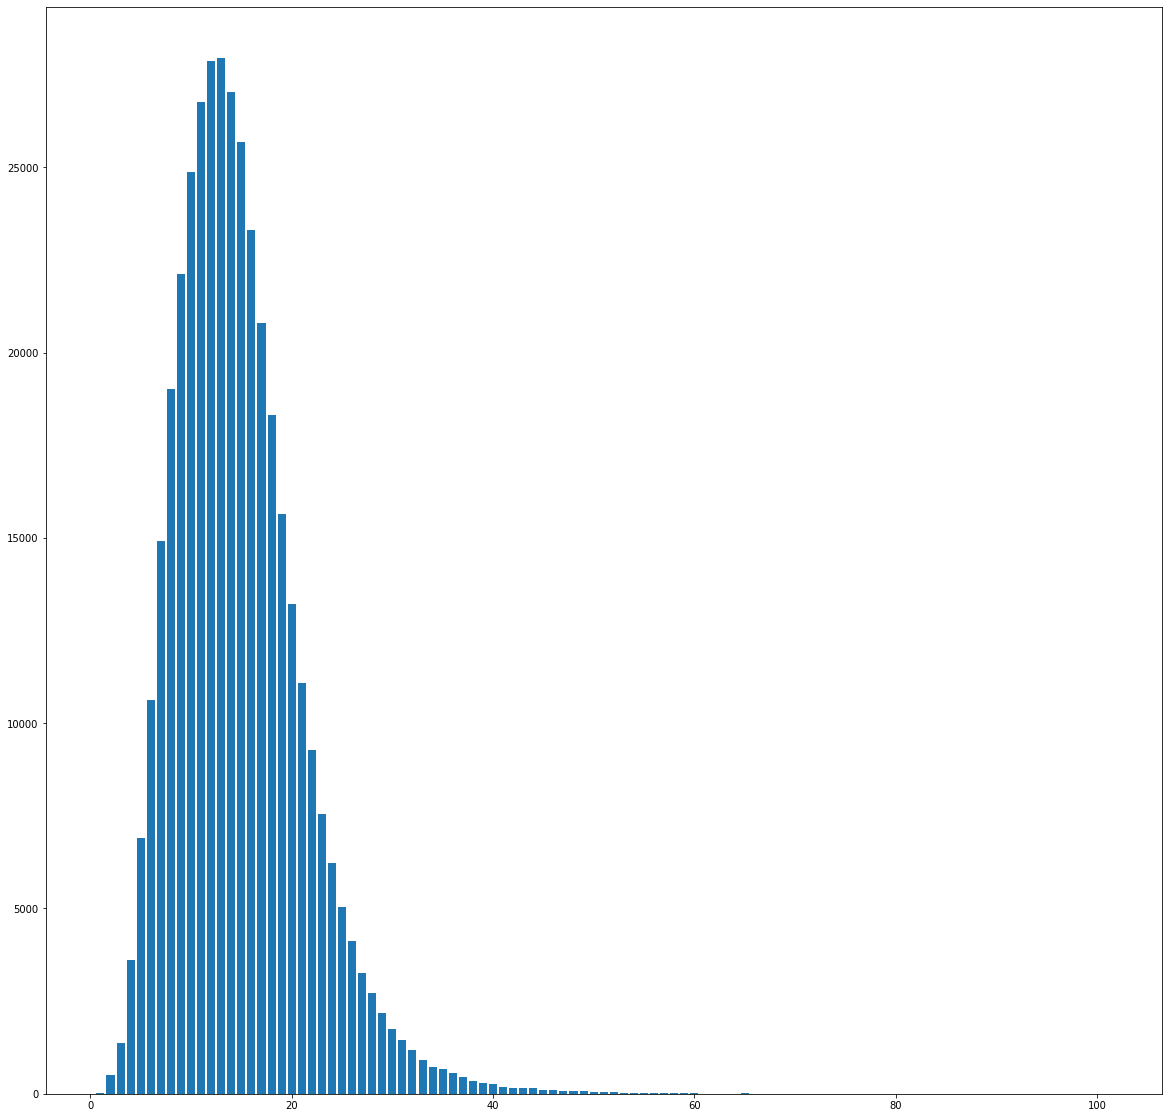

In [ ]:
dict_occurs=train['hypothesis_seq_len'].value_counts().to_dict()
x,y=list(dict_occurs.keys()),list(dict_occurs.values())
seq_len_visualizer(x,y)

In [ ]:
train['total_seq_len']=train['premise_seq_len']+train['hypothesis_seq_len']

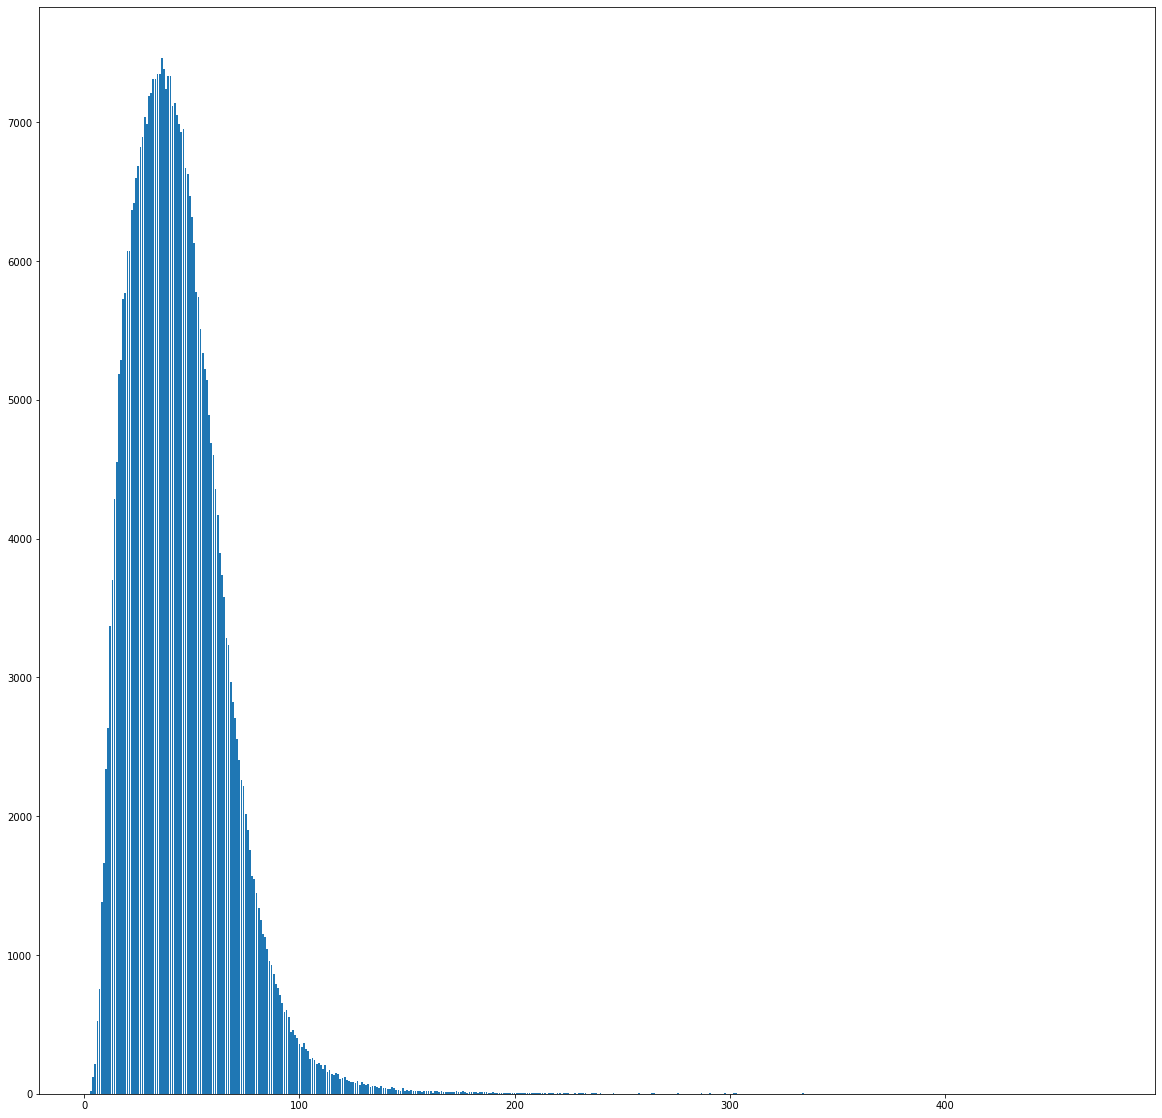

In [ ]:
dict_occurs=train['total_seq_len'].value_counts().to_dict()
x,y=list(dict_occurs.keys()),list(dict_occurs.values())
seq_len_visualizer(x,y)

assign max length 256

In [ ]:
train.value_counts(['label'])

label
2        130676
0        130674
1        130674
dtype: int64

In [ ]:
valid.value_counts(['label'])

label
0        830
1        830
2        830
dtype: int64

In [ ]:
len(train)//5

78404

In [ ]:
for i in range(5):
  train_i=train.iloc[i*78540:(i+1)*78540]
  train_i.to_csv(join(preprocessed_data,f'train_{i}.csv'),index=False)

In [ ]:
valid.to_csv(join(preprocessed_data,'valid.csv'),index=False)

##Create inputs for bert models

In [6]:
train_total=[pd.read_csv(join(preprocessed_data,f'train_{i}.csv')) for i in range(0,5)]

In [7]:
train=pd.concat(train_total,axis=0)

In [8]:
# index=0

In [9]:
# train=pd.read_csv(join(preprocessed_data,f'train_{index}.csv'))

In [10]:
valid=pd.read_csv(join(preprocessed_data,'valid.csv'))

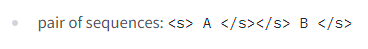

In [11]:
class ClassificationDataset(Dataset):
    def __init__(self, input_ids, attention_mask,labels,device,token_type_ids=None):
        self.labels = labels
        self.input_ids=input_ids
        self.attention_mask=attention_mask
        self.token_type_ids=token_type_ids
        self.device=device
        
    def __len__(self):
            return len(self.labels)

    def __getitem__(self, idx):
        label = self.labels[idx]
        input_ids = self.input_ids[idx]
        attention_mask = self.attention_mask[idx]
        sample = {"inputs":{"input_ids": input_ids.to(self.device),'attention_mask':attention_mask.to(self.device)}, "labels": label.to(self.device)}
        if self.token_type_ids!=None:
          sample['inputs'].update({'token_type_ids':self.token_type_ids[idx].to(self.device)})
        return sample

Note: I found out if i had used default tokenizer, the system would have been crashed.

exp: tokenizer(list_sentences_0 ,list_sentences_1,return_tensors='pt')

So I customized it and my strategy is choose head and tail of sentence if its length is over max_length.

Ref: https://arxiv.org/pdf/1905.05583v3.pdf

In [12]:
def create_input(tokenizer,token_ids_0,token_ids_1=None,max_length=512):
  num_tokens_0=len(token_ids_0)
  num_tokens_1=len(token_ids_1)
  
  threshold_num_tokens_0=max_length-4-num_tokens_1
  if threshold_num_tokens_0<0:
    return None
  trade_off=abs(threshold_num_tokens_0-num_tokens_0)
  if num_tokens_0>threshold_num_tokens_0:
    
    head_token_ids_0=token_ids_0[:threshold_num_tokens_0]
    tail_token_ids_0=token_ids_0[-threshold_num_tokens_0:]

    head_input_ids=tokenizer.build_inputs_with_special_tokens(head_token_ids_0,token_ids_1)
    head_attention_mask=[1]*len(head_input_ids)

    tail_input_ids=tokenizer.build_inputs_with_special_tokens(tail_token_ids_0,token_ids_1)
    tail_attention_mask=[1]*len(tail_input_ids)
    
    input_ids=[head_input_ids,tail_input_ids]

    attention_mask=[head_attention_mask,tail_attention_mask]
  else:
    input_ids=tokenizer.build_inputs_with_special_tokens(token_ids_0,token_ids_1)
    attention_mask=[1]*len(input_ids)
    input_ids=input_ids+[1]*trade_off
    attention_mask=attention_mask+[0]*trade_off
    input_ids=[input_ids]
    attention_mask=[attention_mask]
  return input_ids,attention_mask

In [13]:
def create_inputs(tokenizer,list_sentences_0,list_sentences_1,list_labels,max_length=512):
  
  input_ids=[]
  labels=[]
  bar=tqdm(list_sentences_0)
  attention_mask=[]
  num_training_samples=len(list_sentences_0)
  for i in range(num_training_samples):
    token_ids_0=tokenizer.encode(list_sentences_0[i],add_special_tokens=False)
    token_ids_1=tokenizer.encode(list_sentences_1[i],add_special_tokens=False)
    _input_ids,_attention_mask=create_input(tokenizer,token_ids_0,token_ids_1,max_length)
    
    _labels=[list_labels[i]]*len(_input_ids)
    labels+=_labels
    input_ids+=_input_ids
    attention_mask+=_attention_mask
    bar.update()  
  return {
    'input_ids':torch.Tensor(input_ids).to(torch.long),
    'attention_mask':torch.Tensor(attention_mask).to(torch.int),
    'labels':torch.Tensor(labels).to(torch.long)
}

In [14]:
train_batch_size=32
train_premises=train['clean_premise'].tolist()
train_hypothesises=train['clean_hypothesis'].tolist()
train_labels=train['label'].tolist()

In [15]:
def create_dataloader(tokenizer,list_sentences_0,list_sentences_1,list_labels,max_length=512,batch_size=32,drop_last=False,shuffle=True,device='cpu'):
  dataloader=create_inputs(tokenizer,list_sentences_0,list_sentences_1,list_labels,max_length)

  dataloader=ClassificationDataset(**dataloader,device=device)
  dataloader=DataLoader(dataloader,batch_size=batch_size,drop_last=drop_last,shuffle=shuffle)
  return dataloader

In [16]:
train_dataloader=create_dataloader(tokenizer,train_premises,train_hypothesises,train_labels,max_length,train_batch_size,device=device)

  0%|          | 0/392024 [00:00<?, ?it/s]

In [17]:
valid_batch_size=32
valid_premises=valid['clean_premise'].tolist()
valid_hypothesises=valid['clean_hypothesis'].tolist()
valid_labels=valid['label'].tolist()

In [18]:
valid_dataloader=create_dataloader(tokenizer,valid_premises,valid_hypothesises,valid_labels,max_length,valid_batch_size,device=device)

  0%|          | 0/2490 [00:00<?, ?it/s]

In [19]:
labels=[0,1,2]
labels

[0, 1, 2]

#Trainer

In [22]:
epochs=30
num_training_steps=epochs *len(train_dataloader)
num_warmup_steps=500
init_lr=1e-5
eps =1e-8

In [23]:
len(train_dataloader),num_training_steps,num_warmup_steps

(12322, 369660, 500)

In [24]:
num_labels=len(labels)
num_labels

3

In [25]:
classifier_dropout=0.1

In [26]:
config=AutoConfig.from_pretrained(name)
config.classifier_dropout=classifier_dropout
config.num_labels=num_labels
config

XLMRobertaConfig {
  "_name_or_path": "xlm-roberta-base",
  "architectures": [
    "XLMRobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": 0.1,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "xlm-roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.19.2",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 250002
}

In [27]:
model_index=join(model_name,f'model_total')
model_index

'/content/drive/MyDrive/vi-nli/models/xlm-roberta-base-128/model_total'

In [28]:
config.save_pretrained(model_name)

In [29]:
model=AutoModelForSequenceClassification.from_pretrained(name,config=config).to(device)

Downloading:   0%|          | 0.00/1.04G [00:00<?, ?B/s]

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForSequenceClassification: ['lm_head.dense.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.out_p

In [30]:
optimizer=torch.optim.AdamW(model.parameters(),lr=init_lr,weight_decay =0.01,eps=eps)

In [ ]:
#load pretrain from previous model

# checkpoint = torch.load(f'/content/drive/MyDrive/vi-nli/models/xlm-roberta-base-256/model_{str(index-1)}/ckpt0.pt',map_location=device)

In [ ]:
# min_loss=checkpoint['valid_loss']
# min_loss

In [ ]:
# model.load_state_dict(checkpoint['model_state_dict'])

In [ ]:
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

In [ ]:
# del checkpoint

In [31]:
lr_scheduler=get_linear_schedule_with_warmup(optimizer,num_warmup_steps=num_warmup_steps,num_training_steps=num_training_steps,)

In [32]:
def save_model(epoch,model,optimizer,training_loss,valid_loss,path,step=None):
  torch.save({
          'epoch': epoch,
          'model_state_dict': model.state_dict(),
          'optimizer_state_dict': optimizer.state_dict(),
          'training_loss': training_loss,
          'valid_loss': valid_loss,
          'step':step
          }, join(path,f'ckpt{epoch}.pt'))

In [37]:
def run_train(optimizer,dataloader,lr_scheduler):
  model.train(True)
  loop = tqdm(dataloader)
  loss=0
  for batch in dataloader:
    # model.zero_grad(set_to_none=True)
    optimizer.zero_grad()
    inputs=batch['inputs']
    inputs.update({"labels":batch['labels']})
    outputs=model(**inputs)
    # _loss = loss_fn(logits.view(-1, num_labels), batch['labels'].view(-1))
    outputs.loss.backward()

    loss+=outputs.loss.item()
    optimizer.step()
    lr_scheduler.step()
    loop.set_postfix({f'train_loss_per_batch':outputs.loss.item()})
    loop.update()      
    
  return loss/len(dataloader)

In [38]:
def run_valid(dataloader):
  model.eval()
  loss=0
  with torch.no_grad():
    for batch in dataloader:
      inputs=batch['inputs']
      inputs.update({"labels":batch['labels']})
      outputs=model(**inputs)

      # _loss = loss_fn(logits.view(-1, num_labels), batch['labels'].view(-1))

      loss+=outputs.loss.item()

  return loss/len(dataloader)

In [ ]:
train_loss_per_step=[]
valid_loss_per_step=[]
min_loss=np.inf
count_stopping=0
for epoch in range(epochs):

  train_loss=run_train(optimizer,train_dataloader,lr_scheduler)
  
  valid_loss=run_valid(valid_dataloader)

  train_loss_per_step.append(train_loss)
  valid_loss_per_step.append(valid_loss)
  
  print(f'epoch: {epoch} train_loss: {train_loss} valid_loss: {valid_loss}')
  if valid_loss<min_loss:
    min_loss=valid_loss
    save_model(epoch,model,optimizer,train_loss,valid_loss,model_index)
    count_stopping=0
  else:
    count_stopping+=1
  
  if count_stopping>5:
    break


  0%|          | 0/12322 [00:00<?, ?it/s]

#Inference

In [ ]:
import pandas as pd
test=pd.read_csv('/content/drive/MyDrive/vi-nli/raw_dataset/test.csv')
test  

,premise,hypothesis,label
0,"Vâng, tôi thậm chí không nghĩ về điều đó, nhưn...",Tôi đã không nói chuyện với anh ta nữa.,2
1,"Vâng, tôi thậm chí không nghĩ về điều đó, nhưn...",Tôi buồn tới mức tôi lại bắt đầu nói chuyện lạ...,0
2,"Vâng, tôi thậm chí không nghĩ về điều đó, nhưn...",Chúng tôi có buổi nói chuyện tuyệt vời.,1
3,"Và tôi nghĩ đó là một đặc ân, và nó vẫn còn, n...",Tôi không nhận ra rằng tôi không phải là người...,1
4,"Và tôi nghĩ đó là một đặc ân, và nó vẫn còn, n...",Tôi có ấn tượng là tôi là người duy nhất có số...,0
...,...,...,...
5005,Davidson không nên áp dụng cách phát âm chữ sc...,Davidson không nên nói theo cách mà xương và â...,0
5006,Davidson không nên áp dụng cách phát âm chữ sc...,Sẽ tốt hơn nếu Davidson vần các từ và xương.,2
5007,Tiểu thuyết trung bình có 200.000 từ giá khoản...,Một cuốn tiểu thuyết 200.000 từ với giá 25 đô ...,1
5008,Tiểu thuyết trung bình có 200.000 từ giá khoản...,Một cuốn tiểu thuyết 200.000 từ với giá 25 USD...,2


In [ ]:
config = AutoConfig.from_pretrained(f'{model_name}/config.json')
config._name_or_path=name

In [ ]:
model=AutoModelForSequenceClassification.from_pretrained(name,config=config).to(device)

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForSequenceClassification: ['lm_head.dense.weight', 'lm_head.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense

In [ ]:
checkpoint = torch.load("/content/drive/MyDrive/vi-nli/models/xlm-roberta-base-256/ckpt2.pt",map_location=device)

In [ ]:
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [ ]:
y_true=test['label'].tolist()

In [ ]:
def predict(premises,hypothesises,max_length,return_tensors='pt',device='cpu',normalizer=None):
  #premises: list of texts
  #hypothesises: list of texts
  #normalizer: function -> clean dataset and return a new input with the same format
  model.eval()
  y_pred=[]
  with torch.no_grad():
    loop = tqdm(range(len(premises)))
    for idx,sample in enumerate(zip(premises,hypothesises)):
      if normalizer!=None:
        premise=normalizer(sample[0])
        hypothesis=normalizer(sample[1])
      _inputs=tokenizer(premise,hypothesis,padding=True,truncation=True,max_length=max_length,return_tensors=return_tensors).to(device)
      outputs=model(**_inputs)
      
      probs=torch.nn.functional.softmax(outputs.logits,dim=1)
      preds=torch.argmax(probs,dim=1)
      y_pred.append(preds)
      loop.update()
  return torch.Tensor(y_pred)

In [ ]:
y_pred=predict(test['premise'].tolist(),test['hypothesis'].tolist(),max_length,device=device,normalizer=normalizer)

In [ ]:
y_pred

tensor([0., 0., 1.,  ..., 1., 0., 0.])

In [ ]:
y_pred=y_pred.tolist()

#Conclusion

with train_0

In [ ]:
print(classification_report(y_true,y_pred,digits=5))

In [ ]:
confusion_matrix(y_true,y_pred)